In [1]:
import numpy as np
from scipy import spatial 
import faiss
from time import time
import matplotlib.pyplot as plt

## Helper Function

In [2]:
def semi_optimized_exhaustive_search(
        index_vectors: np.ndarray,
        query_vectors: np.ndarray,
        k: int,
):
    """
    This function performs an optimized exhaustive search.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        dim: The dimensionality of the vectors.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
    """
    ann_lists = []
    for query_vec in query_vectors:
        distances = np.linalg.norm(index_vectors - query_vec, axis=1)
        ann_lists.append(list(np.argsort(distances)[:k]))
    return np.array(ann_lists)

In [3]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [4]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [5]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [21]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 2.1 -- LSH vs Naive Exhaustive Search (Regular Index Vectors)
### You just have to run the following cells and add the following results to the report:
* running time of the ground truth computation with semi_optimized_exhaustive_search (wall time)
* running time of creating faiss_lsh_index (wall time)
* running time of faiss_search over query_vectors with faiss_lsh_index (wall time)
* recall@10 for faiss_lsh_ann

In [7]:
query_vectors = np.load('data/query_vectors.npy').astype(np.float32)
index_vectors = np.load('data/index_vectors.npy').astype(np.float32)
k=10
dim = index_vectors.shape[1]
query_vectors.shape, index_vectors.shape

((1000, 100), (20000, 100))

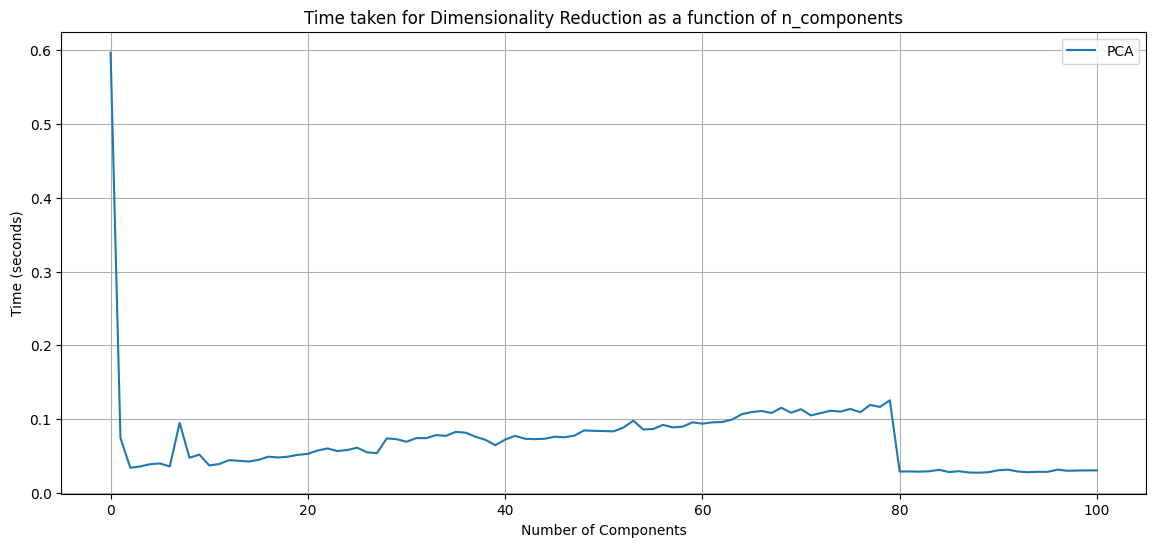

In [8]:
from sklearn.decomposition import PCA

# Define the range of n_components to test
n_components_range = range(101)

# Measure time for PCA
pca_times = []
for n_components in n_components_range:
    start_time = time()
    pca = PCA(n_components=n_components)
    pca.fit_transform(index_vectors)
    pca_times.append(time() - start_time)

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(n_components_range, pca_times, label='PCA')
plt.xlabel('Number of Components')
plt.ylabel('Time (seconds)')
plt.title('Time taken for Dimensionality Reduction as a function of n_components')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
%%time
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)

CPU times: user 4.97 s, sys: 3.58 ms, total: 4.98 s
Wall time: 4.98 s


In [10]:
import time

start_time = time.time()
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)
end_time = time.time()

semi_optimized_exhaustive_search_time = end_time - start_time
print(f"Elapsed time: {semi_optimized_exhaustive_search_time:.2f} seconds")


Elapsed time: 5.04 seconds


In [11]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors, dim, nbits=2000)

CPU times: user 2.84 s, sys: 331 ms, total: 3.17 s
Wall time: 430 ms


In [12]:
%%time
faiss_lsh_ann = faiss_search(query_vectors, faiss_lsh_index, k)

CPU times: user 5.77 s, sys: 121 ms, total: 5.89 s
Wall time: 545 ms


In [13]:
faiss_lsh_ann.shape, type(faiss_lsh_ann)

((1000, 10), numpy.ndarray)

In [14]:
print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(gt_nn, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.138


# 2.2 -- Custom Indexing Algorithm
Build an indexing algorithm that satisfies the following requirements:
* The indexing algorithm should be able to handle vectors of different dimensions
* The running time of the indexing should be less than half of the running time of semi_optimized_exhaustive_search), reported in Section 2.1.
* The running time of searching over the index should be less than a third (1/3) of the time of the semi_optimized_exhaustive_search function, reported in Section 2.1.
* The performance (in terms of recall@10) of the indexing algorithm should be at least 0.8.

The last three bullets should also appear in the report.
You are allowed to add as many helper functions as you need. You cannot use faiss of scipy libraries for this task. Numpy is allowed. 

You can also test your algorithm with the additional two query-index sets by replacing the calls made few cells ago to:

    query_vectors = np.load('data/query_vectors2.npy')
    index_vectors = np.load('data/index_vectors2.npy')
or:

    query_vectors = np.load('data/query_vectors3.npy')
    index_vectors = np.load('data/index_vectors3.npy')
    
the aforementioned requirements should also be satisfied over these two query-index sets. No need to insert the results over these two to the report.

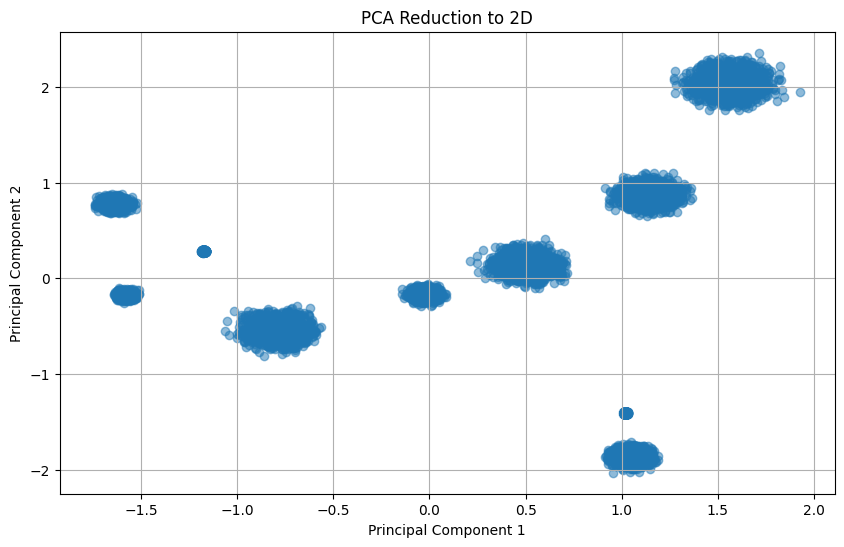

In [48]:
# Perform PCA
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(index_vectors)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], alpha=0.5)
plt.title('PCA Reduction to 2D')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
mask = (index_vectors>0.5).astype(int)
pca = PCA(n_components=2)
reduced_mask_pca = pca.fit_transform(mask)

# Rotate the data by swapping axes and negating one axis
rotated_reduced_mask_pca = np.column_stack((reduced_mask_pca[:, 1], reduced_mask_pca[:, 0]))

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(rotated_reduced_mask_pca[:, 0], rotated_reduced_mask_pca[:, 1], alpha=0.5)
plt.title('PCA Reduction to 2D (Rotated 90 Degrees Counterclockwise)')
plt.xlabel('Principal Component 2')
plt.ylabel('Negative Principal Component 1')
plt.grid(True)
plt.show()

In [ ]:
%%time
custom_index = custom_indexing_algorithm(index_vectors)

In [ ]:
%%time
custom_index_ann = custom_index_search(query_vectors, custom_index)

In [ ]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn, np.array(custom_index_ann), k)}")

# IVF

In [25]:
class IVF:
    def __init__(self, index_vectors, num_clusters):
        self.index_vectors = index_vectors
        self.num_clusters = num_clusters
        self.centroids = None
        self.index = None

    def build_ivf_index(self):
        centroids, labels = kmeans(self.index_vectors, self.num_clusters) # Running K-means 
        ivf_index = {i: [] for i in range(self.num_clusters)} # Preparing the index structure
        
        for i, label in enumerate(labels):
            ivf_index[label].append(i)  # Store the index of the vector instead of the vector itself
        
        self.centroids = centroids
        self.index = ivf_index
        
def kmeans(X, k, max_iters=1): # Just a simple implementation of K-means algorithm
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, k, replace=False)] # Initialize centroids with K randomly chosen samples
    
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2) # Calculate distances from centroids
        labels = np.argmin(distances, axis=1) # Choose closest centroid
        
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)]) # Create new centroids
        
        if np.all(centroids == new_centroids): # Break if the algorithm converges
            break
        
        centroids = new_centroids # Update rule
    
    return centroids, labels


def search_ivf_index(ivf_index, query_vector, index_vectors, k_neighbors=10, n_probe=3):
    centroids = ivf_index.centroids
    index = ivf_index.index
    
    distances = np.linalg.norm(centroids - query_vector, axis=1) # Efficient distance calculation using NumPy broadcasting
    closest_clusters = np.argsort(distances)[:n_probe]
    
    # Gather candidate indices and vectors
    candidate_indices = np.concatenate([index[cluster] for cluster in closest_clusters])
    candidate_vectors = index_vectors[candidate_indices]
    
    candidate_distances = np.linalg.norm(candidate_vectors - query_vector, axis=1) # Efficient distance calculation using NumPy broadcasting
    
    top_indices = np.argsort(candidate_distances)[:k_neighbors]
    
    return candidate_indices[top_indices]

In [26]:
def custom_indexing_algorithm(index_vectors, dim, k=10):
    """
    This function builds an index from scratch.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
        k: Number of clusters for IVF.
    Returns:
        An index and centroids.
    """
    ivf = IVF(index_vectors, k)
    ivf.build_ivf_index()
    return ivf

def custom_index_search(query_vectors, ivf, index_vectors, top_n=10, n_probe=3):
    """
    This function searches over the custom index.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        ivf: The custom index (IVF object).
        index_vectors: The original index vectors.
        top_n: The number of nearest neighbors to retrieve.
        n_probe: The number of clusters to probe.
    Returns:
        An array of nearest neighbors for each query vector.
    """
    results = []
    for query_vector in query_vectors:
        retrieved_indices = search_ivf_index(ivf, query_vector, index_vectors, k_neighbors=top_n, n_probe=n_probe)
        results.append(retrieved_indices)
    return results


In [17]:
indexing_threshold = (1/2)*semi_optimized_exhaustive_search_time
searching_threshold = (1/3)*semi_optimized_exhaustive_search_time
print(f'Indexing running-time threshold: {indexing_threshold:.04}')
print(f'Searching over the index running-time threshold: {searching_threshold:.04}')


Indexing running-time threshold: 2.522
Searching over the index running-time threshold: 1.682


In [50]:
%%time
custom_index = custom_indexing_algorithm(index_vectors, dim, k=25)

CPU times: user 113 ms, sys: 104 ms, total: 218 ms
Wall time: 215 ms


In [51]:
%%time
custom_index_ann = custom_index_search(query_vectors, custom_index, index_vectors)


CPU times: user 1.34 s, sys: 2 µs, total: 1.34 s
Wall time: 1.34 s


In [52]:
print(f"recall@10 for our custom index: {compute_recall_at_k(gt_nn, np.array(custom_index_ann), k)}")

recall@10 for our custom index: 0.891


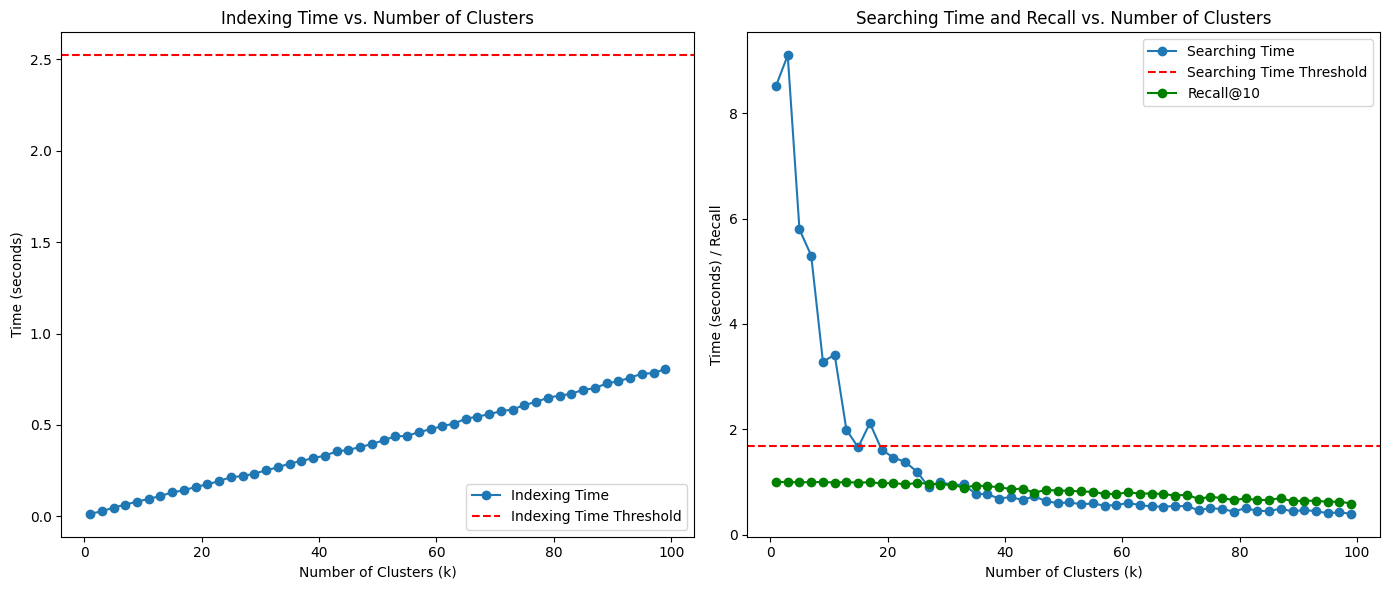

In [55]:

# Define the range of k values to test
k_values = np.arange(1,101,2)

# Lists to store the results
indexing_times = []
searching_times = []
recalls = []

for k in k_values:
    # Measure indexing time
    start_time = time.time()
    custom_index = custom_indexing_algorithm(index_vectors, index_vectors.shape[1], k=k)
    indexing_time = time.time() - start_time
    
    # Measure searching time
    start_time = time.time()
    custom_index_ann = custom_index_search(query_vectors, custom_index, index_vectors)
    searching_time = time.time() - start_time
    
    # Compute recall@10
    recall = compute_recall_at_k(gt_nn, np.array(custom_index_ann), k=10)
    
    # Store results
    indexing_times.append(indexing_time)
    searching_times.append(searching_time)
    recalls.append(recall)

# Plotting the results
plt.figure(figsize=(14, 6))

# Plot indexing times
plt.subplot(1, 2, 1)
plt.plot(k_values, indexing_times, label='Indexing Time', marker='o')
plt.axhline(indexing_threshold, color='r', linestyle='--', label='Indexing Time Threshold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Time (seconds)')
plt.title('Indexing Time vs. Number of Clusters')
plt.legend()

# Plot searching times and recall
plt.subplot(1, 2, 2)
plt.plot(k_values, searching_times, label='Searching Time', marker='o')
plt.axhline(searching_threshold, color='r', linestyle='--', label='Searching Time Threshold')
plt.plot(k_values, recalls, label='Recall@10', marker='o', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Time (seconds) / Recall')
plt.title('Searching Time and Recall vs. Number of Clusters')
plt.legend()

plt.tight_layout()
plt.show()